# Code alongs - overfitting and underfitting

## Simulate data 

$y = a_0 + a_1x + a_2x^2 + \epsilon$

where $\epsilon \sim \mathcal{N}(0,1)$ (the error is standard normal distributed)

In [20]:
import numpy as np 
import matplotlib.pyplot as plt 

samples = 100 
X = np.random.uniform(-3,3, (samples, 1))
X.shape

(100, 1)

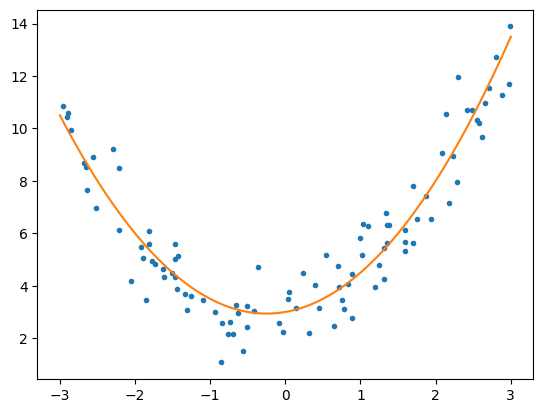

In [21]:
# a0 = 3, a1 = 0.5, a2 = 1
f = lambda x: x**2 + 0.5*x + 3
# y = a0 + a1x + a2x^2 + epsilon
y = f(X) + np.random.randn(samples, 1)

# linspace gives equally spaced numbers between low and high
# between -3 and 3 we get 100 equally spaced numbers
x = np.linspace(-3,3, samples )

plt.plot(X,y, '.')
plt.plot(x, f(x))

<Axes: title={'center': '$y = x^2+0.5x+3+\\epsilon$'}>

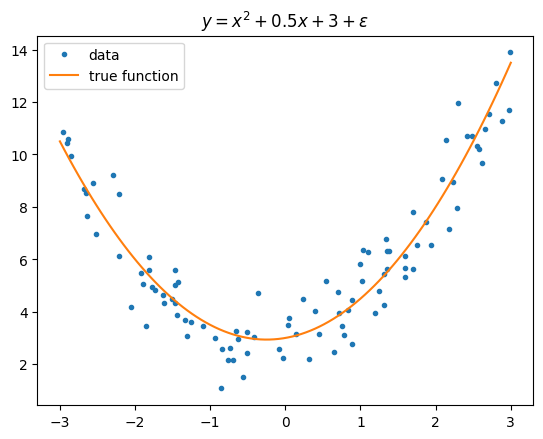

In [22]:
def draw_data():
    fig, ax = plt.subplots()
    ax.plot(X,y, '.', label="data")
    ax.plot(x, f(x), label="true function")
    ax.set(title = r"$y = x^2+0.5x+3+\epsilon$")
    ax.legend()

    return ax
draw_data()

## Polynomial regression

In [23]:
X[:5], X.shape

(array([[-0.56789022],
        [-1.85485869],
        [ 0.71726032],
        [-1.9271402 ],
        [-1.88878608]]),
 (100, 1))

### Feature engineering

- created polynomial features from the dataset

In [24]:
from sklearn.preprocessing import PolynomialFeatures

# include_bias = True -> a column of 1s are included, and if false its excluded
# we use False as LinearRegression() handles the bias 
# instantiate a PolynomialFeatures instance from the PolynomialFeatures class 
poly = PolynomialFeatures(degree=2, include_bias=False)

# from X had [x1] -> now it has [x1 x1^2] 
poly_features = poly.fit_transform(X)
poly_features[:5], poly_features.shape

(array([[-0.56789022,  0.3224993 ],
        [-1.85485869,  3.44050076],
        [ 0.71726032,  0.51446237],
        [-1.9271402 ,  3.71386935],
        [-1.88878608,  3.56751285]]),
 (100, 2))

In [25]:
0.84185556**2,0.73626708**2, (-1.21960794)**2

(0.7087207839029135, 0.5420892130917263, 1.4874435273110436)

### Train on transformed dataset

- use multiple linear regression on our polynomial features
- this gives us polynomial regression of second order

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(poly_features, y)

# estimated: a1, a2 from data, note that true value was a1=0.5, a2=1
model.coef_

array([[0.49480454, 0.99009965]])

In [27]:
# estimated a0 from data, note that true a0 = 3
model.intercept_

array([2.94165991])

### Visualise true model and estimated model

In [28]:
# x is our linspace, its 1 dimensional
x[:5], x.shape

(array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576]),
 (100,))

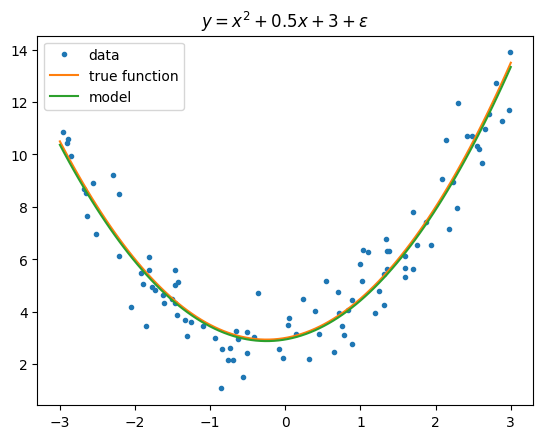

In [29]:
x_poly_features = poly.transform(x.reshape(-1,1))
y_pred = model.predict(x_poly_features)

ax = draw_data()
ax.plot(x, y_pred, label="model")
ax.legend()

### Underfitting

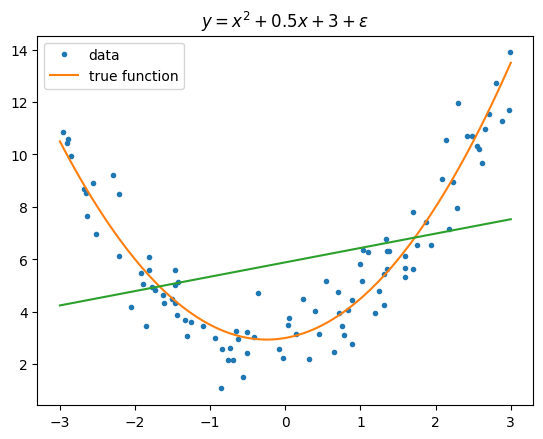

In [30]:
model = LinearRegression()
# we haven't transformed the feature space, so we get a linear model
model.fit(X,y)
ax = draw_data()
ax.plot(x, model.predict(x.reshape(-1,1)))

### Overfitting

In [31]:
poly_model_30 = PolynomialFeatures(30, include_bias=False)

X_features = poly_model_30.fit_transform(X)
X_features.shape

(100, 30)

In [32]:
x_poly_features = poly_model_30.transform(x.reshape(-1,1))
x_poly_features.shape

(100, 30)

[(-1.0, 15.0), Text(0.5, 1.0, 'Overfitted model')]

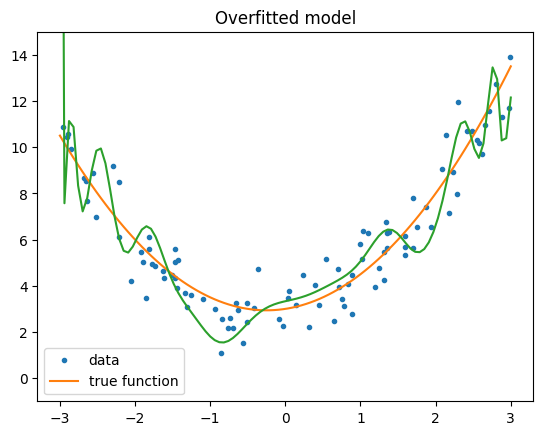

In [33]:
model = LinearRegression()
model.fit(X_features, y)

y_pred = model.predict(x_poly_features)

ax = draw_data()
ax.plot(x, y_pred)
ax.set(ylim=[-1,15], title="Overfitted model")

## Choose a model

In [34]:
# simulate new data 
samples = 10000
X = np.random.uniform(-3,3, (samples, 1 ))
X.shape

(10000, 1)

In [35]:
f = lambda x: x**4 + x**2 +.5*x + 3
y = f(X) + np.random.randn(samples, 1)

y.shape

(10000, 1)

### Train|Validation|Test split

split dataset into
- train - train on training set
- validation - tune hyperparameter on validation set
- test - evaluate on test set

in our case the degree is a hyperparameter

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# use test set and take half of it to use as test and half as validation
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# 2/3 train 
# 1/3/2 val
# 1/3/2 test

X_train.shape, X_val.shape, X_test.shape

((6700, 1), (1650, 1), (1650, 1))

### Train model and predict on validation

In [38]:
from sklearn.metrics import mean_squared_error

RMSE_val = []

for degree in range(1,100):
    model_poly = PolynomialFeatures(degree, include_bias=False)
    # feature engineering -> transformed feature space
    train_features = model_poly.fit_transform(X_train)
    val_features = model_poly.fit_transform(X_val)

    model_linear_regression = LinearRegression()
    # polynomial regression - trains on transformed feature space
    model_linear_regression.fit(train_features, y_train)

    # predict on validation data
    y_pred_val = model_linear_regression.predict(val_features)
    RMSE_val.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))

[Text(0.5, 0, 'Degree'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'RMSE on validation data for different degrees of polynomials')]

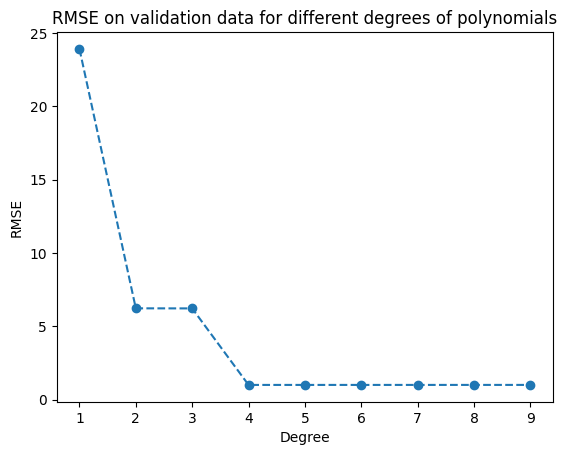

In [40]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), RMSE_val[:9], "--o")
ax.set(
    xlabel="Degree",
    ylabel="RMSE",
    title="RMSE on validation data for different degrees of polynomials",
)

### TODO for reader: 

- use degree 4 and train on training data + validation data 
- evaluate on test data -> see previous lecture